# Gather reports related to public health

## Import libraries

In [1]:
import json
import requests
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Set variables

In [2]:
BASE_URL = "https://api.figshare.com/v2"

In [3]:
categories = ["'Public Health and Health Services not elsewhere classified'","'Health Promotion'","'Public health not elsewhere classified'","'Health Policy'","'Health and Community Services'",
             "'Urban planning and health'","'Health and community services'","'Indigenous health'","'Health surveillance'","'Global Indigenous studies health and wellbeing'","'Community Child Health'",
             "'Community child health'"]



In [4]:
test = ["'Community child health'"]

In [7]:
#Gather basic metadata for items (articles) that meet your search criteria
results = []
for i in categories:
    query = '{"item_type": 18, "search_for":":category: ' + i + '"}' #Search for reports
    y = json.loads(query) #Figshare API requires json paramaters
    for j in range(1,10):
        records = json.loads(requests.post(BASE_URL + '/articles/search?page_size=1000&page={}'.format(j), params=y).content)
        results.extend(records)
    
#See the number of articles
print(len(results),'articles retrieved')

276 articles retrieved


In [8]:
#Save the json.
with open('pub-health-reports'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(results, f)

In [9]:
#Create a dataframe from the JSON formatted data
dfall = pd.DataFrame(results)

In [13]:
#Remove duplicates
dfunique = dfall.drop_duplicates(subset='id', keep="first")
print(len(dfall)-len(dfunique),'records removed,',len(dfunique),'unique records remain')

50 records removed, 226 unique records remain


In [17]:
#Remove records that have a handle not a doi - this doesn't work and you don't need to do this
#nan_value = float("NaN")
#dfuniquedoi = dfunique.copy()
#dfuniquedoi.replace("", nan_value, inplace=True) #Replace blanks with nan
#dfuniquedoi.dropna(subset = ["doi"])
#print(len(dfunique)-len(dfuniquedoi),'records removed,',len(dfuniquedoi),'unique records remain')

0 records removed, 226 unique records remain


c:\users\andre.desktop-dfg3gu2\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [19]:
#Save a file of all the metadata
save_file = dfunique.to_csv('pub-health-reports-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

In [19]:
#Open a file if needed
dfunique = pd.read_csv('pub-health-reports-07-01.csv',encoding='utf8')

In [21]:
#Create a list of all the article ids
article_ids = dfunique['id'].tolist()

In [22]:
#article_ids2 = article_ids[12679:16047]
len(article_ids)

226

In [23]:
# Create a csv file, use an API to gather data, reopen the csv as a dataframe
   

#Create csv file
metadata=open('article-stats'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv', 'w', newline='')
#Write header row to csv
csv.writer(metadata).writerow(['id','views','downloads','shares'])            

            
for l in article_ids:
    s=requests.get('https://stats.figshare.com/total/views/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    r=json.loads(s.text)
    t=requests.get('https://stats.figshare.com/total/downloads/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    q=json.loads(t.text)
    u=requests.get('https://stats.figshare.com/total/shares/article/'+ str(l),headers={"mailto":"andrew@figshare.com"})
    v=json.loads(u.text)
    
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    csv.writer(metadata).writerow([
        l,
        r.get('totals'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
        q.get('totals'),
        v.get('totals')]) 
    
    
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfstats = pd.read_csv('article-stats'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv',encoding='utf8')

print('The resulting dataframe has',len(dfstats),'rows')

The resulting dataframe has 226 rows


In [13]:
#Open existing file if needed
dfstats = pd.read_csv('article-stats-all-2022-07-02.csv',encoding='utf8')

In [24]:
df_full1 = dfunique.merge(dfstats, how='left', on='id').reset_index(drop=True) #left to keep all records, the stats frame is missing 3

### Gather keyword, category, funder, license, number of files metadata

In [25]:
def exists(obj, chain):
    _key = chain.pop(0)
    if _key in obj:
        return exists(obj[_key], chain) if chain else obj[_key]

#-----------------------------Create csv files---------------------------------------
metadata=open('extra-metadata.csv', 'w', encoding='utf-8', newline='')
#Write header row to csv

csv.writer(metadata).writerow(['id','license','categories','tags','funders','count_references','count_files'])


for i in article_ids:
    record = json.loads(requests.get('https://api.figshare.com/v2/articles/' + str(i)).content)
    #Get publish date, title, categories
    #First get a list of category names and funder information from record
    cats = []
    for c in record['categories']:
        cats.append(c['title'])
    
    funders = [] #funder name might be duplicated across multiple grants for an item. Create a dictionary to deduplicate later
    for f in record['funding_list']:
        entry = {"id":i, "funder_name":f['funder_name']}
        funders.append(entry)

    
    #Then write to csv
    csv.writer(metadata).writerow([
                    i,
                    record['license']['name'],
                    cats,
                    record['tags'],
                    funders,
                    len(exists(record,['references'])) if exists(record,['references'])!=None else 0,
                    len(exists(record,['files'])) if exists(record,['files'])!=None else 0
                    ])


metadata.close() #Close the output file, release all locks


#Load file just created as a dataframe
metadata = pd.read_csv('extra-metadata.csv')


print(len(metadata),"records collected")



226 records collected


In [26]:
df_full = df_full1.merge(metadata, how='inner', on='id').reset_index(drop=True)

In [27]:
#Save the json.
with open('pub-health-reports-funding'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(funders, f)

In [5]:
#Are any missing stats?
missing_stats = df_full[df_full['views'].isna()]
missing_stats.head()

,Unnamed: 0,project_id,id,title,doi,handle,url,published_date,thumb,defined_type,...,resource_doi,views,downloads,shares,license,categories,tags,funders,count_references,count_files


In [28]:
#Save a file of all the metadata
save_file = df_full.to_csv('RAW-pub-health-reports-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

## Format dates and time related columns

In [2]:
#Open a file if needed
df_full = pd.read_csv('RAW-pub-health-reports-2022-07-15.csv',encoding='utf8')
len(df_full)

226

In [3]:
with open("pub-health-reports2022-07-15.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    full_records = json.load(read_file)


In [5]:
#The dates are all contained within one column called 'timeline'. Flatten that column and associate the values
#with the proper article id in a new dataframe

temp_date_list = []

for item in full_records:
    dateitem = item['timeline']
    dateitem['id'] = item['id']
    #dateitem['doi'] = item['doi']
    temp_date_list.append(dateitem)

df_dates = pd.json_normalize(
    temp_date_list 
)

#Have to de-duplicate to match df_full
df_ids_unique = df_dates.drop_duplicates(subset='id', keep="first")
#Remove records that have a handle not a doi
#df_dates_full = dfunique[dfunique['doi'] != ""]


#Merge the dataframes
df_full = df_full.merge(df_ids_unique, how='left', on='id').reset_index(drop=True)

print("Dates split out and merged,",len(df_full),'records in dataframe')

Dates split out and merged, 226 records in dataframe


### Calculate views per month since posted

<ipython-input-6-358a186d92db>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize = 12)


[Text(0, 0.0, '0.0'),
 Text(0, 10.0, '10.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 30.0, '30.0'),
 Text(0, 40.0, '40.0'),
 Text(0, 50.0, '50.0'),
 Text(0, 60.0, '60.0'),
 Text(0, 70.0, '70.0'),
 Text(0, 80.0, '80.0')]

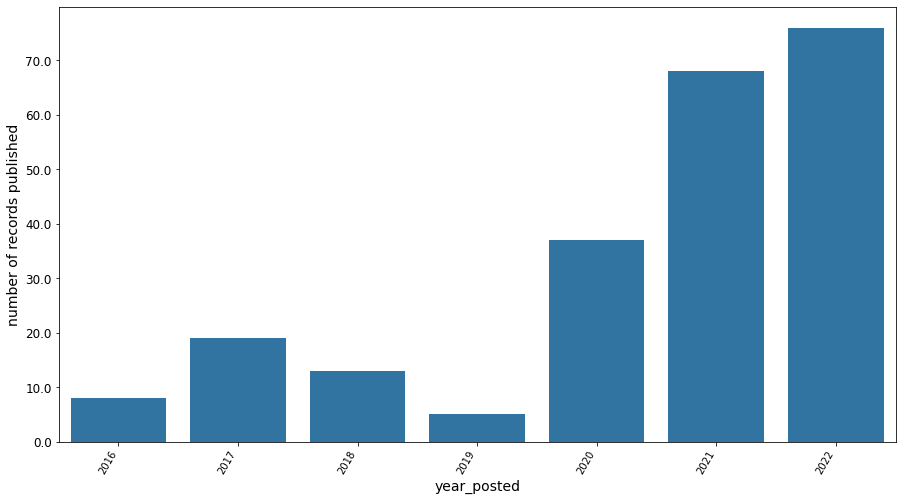

In [6]:
#Use the posted date because the firstOnline date may not align with the actual Figshare record. 
#The posted date as this is the date posted on Figshare.

#Add year and month posted columns
df_full['year_posted'] = pd.DatetimeIndex(df_full['posted']).year
df_full['month_posted'] = pd.DatetimeIndex(df_full['posted']).month

#Another way to do it...Split the year out and add it as a column
#year = df_full["firstOnline"].str.split("-", n = 1, expand = True)
#df_full['year'] = year[0]

#Group by year
datechart = df_full.groupby(['year_posted']).count().reset_index()

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=datechart, x="year_posted", y="id", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("number of records published", fontsize = 14)
ax.set_xlabel("year_posted", fontsize = 14)
ax.set_xticklabels(datechart['year_posted'], fontsize = 10, rotation=60, ha="right")
ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

In [7]:

#Look at views per month

# Could use this: current_year = datetime.datetime.now().year but I hard coded in the month and year for the dataset

def calc(row):
    if row['month_posted'] != 7 and row['year_posted'] == 2022: #If the month is less than data collection month but same year
        return (7-row['month_posted']) #return number of months posted
    elif row['month_posted'] == 7 and row['year_posted'] == 2022: #If posted same month as data collection
        return 0.5 #data was collected July 15 so if item posted in July 2022 just assign it 0.5
    else:
        return ((2022-(row['year_posted']+1))*12)+(12-row['month_posted'])+7 #add 1 to year posted, then subtract to get full years, then add the months from posted year, then months for current year

df_full['months_since_posted'] = df_full.apply(calc, axis=1)
    
df_full['views_per_month'] = df_full['views']/df_full['months_since_posted']
#df_full['log_views_per_month'] = np.log(dfviews['views_per_month'])
#df['downloads_per_month'] = df['downloads']/df['months_since_posted']


In [8]:
#Save a file of all the metadata with dates separated

save_file = df_full.to_csv('MASTER-pub-health-reports-2022-07-15.csv')
#save_file = df_full.to_csv('MASTER-pub-health-reports-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

In [11]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            226 non-null    int64  
 1   project_id            66 non-null     float64
 2   id                    226 non-null    int64  
 3   title                 226 non-null    object 
 4   doi                   195 non-null    object 
 5   handle                31 non-null     object 
 6   url                   226 non-null    object 
 7   published_date        226 non-null    object 
 8   thumb                 202 non-null    object 
 9   defined_type          226 non-null    int64  
 10  defined_type_name     226 non-null    object 
 11  group_id              226 non-null    int64  
 12  url_private_api       226 non-null    object 
 13  url_public_api        226 non-null    object 
 14  url_private_html      226 non-null    object 
 15  url_public_html       2

# Analysis

In [2]:
#Open a file if needed
df_full = pd.read_csv('MASTER-pub-health-reports-2022-07-15.csv',encoding='utf8')
len(df_full)

In [12]:
post_dates = df_full['posted'].tolist()
post_dates.sort()
first_date = post_dates[0]
last_date = post_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

Earliest date: 2016-10-04T01:14:48 ; Most recent date: 2022-07-12T00:23:48


In [13]:
online_dates = df_full['firstOnline'].tolist()
online_dates.sort()
first_date = online_dates[0]
last_date = online_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

Earliest date: 2003-01-01T00:00:00 ; Most recent date: 2022-07-12T00:23:48


In [14]:
pub_dates = df_full['published_date'].tolist()
pub_dates.sort()
first_date = pub_dates[0]
last_date = pub_dates[-1]
print('Earliest date:',first_date,'; Most recent date:',last_date)

Earliest date: 2016-10-04T01:14:48Z ; Most recent date: 2022-07-12T00:23:48Z


In [19]:
#Look at item type list
df_full['defined_type_name'].value_counts()

report    226
Name: defined_type_name, dtype: int64

In [20]:
#Look at license list
df_full['license'].value_counts()

In Copyright                    59
CC BY 4.0                       56
CC BY-NC-SA 4.0                 37
CQUniversity General 1.0        25
CC BY-NC-ND 4.0                 20
CC BY-NC 4.0                     8
CC BY-ND 4.0                     8
CQUniversity Open Access 1.0     7
CC BY-SA 4.0                     3
CC BY 3.0                        1
Public Domain                    1
All Rights Reserved 1.0          1
Name: license, dtype: int64

In [21]:
#Replace the [] with NaN in the funders col. This just has linked funder names
df_full['funders'].replace('[]', np.NaN, inplace = True)


In [23]:
#Count references to at least one funder. I manually counted links to Dimentions = 29
print(df_full['funders'].count(),'records list at least one funder')

142 records list at least one funder


In [24]:
mean_files = df_full['count_files'].mean()
mean_files

1.261061946902655

In [25]:
#Number of records with 1 or fewer files
print(len(df_full[df_full['count_files'] <= 1]),'records with one or fewer files;',
      len(df_full[df_full['count_files'] == 0]),'with zero files;',
      len(df_full[df_full['count_files'] > 1]),'filesets')

      

183 records with one or fewer files; 22 with zero files; 43 filesets


In [27]:
tags = df_full['tags'].to_frame()

#Clean up the strings so each value is words separated by commas and a space
tags['tags_clean'] = tags['tags'].str.replace('[','', regex=False)
tags['tags_clean'] = tags['tags_clean'].str.replace(']','', regex=False)
tags['tags_clean'] = tags['tags_clean'].str.replace("'","", regex=False)

#Create a list to hold the list of words for each row, the tags are added to the sublists based on the ', '
tags_clean = []
for y in tags['tags_clean']:
    value = y.split(', ')
    tags_clean.append(value)

#Make the list of lists to one list:
all_tags = [word for tag in tags_clean for word in tag]
len(all_tags)

1581

In [28]:
all_tags_df = pd.DataFrame(all_tags, columns = ['tag'])
tops = all_tags_df.value_counts()

In [29]:
tops.head(20)

tag                                                       
Public Health and Health Services not elsewhere classified    34
Epidemiology                                                  28
Built Environment and Design not elsewhere classified         26
Urban Policy                                                  25
Urban Analysis and Development                                25
Urban Design                                                  25
Human Geography not elsewhere classified                      25
Health and Community Services                                 17
Health Care                                                   14
Health Information Systems (incl. Surveillance)               13
Health Care Administration                                    13
10,000 steps                                                  11
Physical activity                                             11
Community Child Health                                        11
Primary Health Care            

In [30]:
#How many records are on figshare.com, that is, don't have a group_id
test = df_full['group_id'].isna().sum()
test

0